In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = F.relu(out)
        return out
    
# 定义ResNet-18网络
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels: # 若两个卷积前后的图像尺寸有变化,定义一条捷径
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels)) # 创建残差块并添加
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [3]:
# 定义模型训练函数
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(inputs)  # 进行前向传播
        
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_loss += loss.item()
        
        # 计算准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc

# 定义模型测试函数
def test_model(model, test_loader, device):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    
    with torch.no_grad():  # 在测试时不需要计算梯度
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

In [4]:
# 定义主函数
def main(train_loader, val_loader, test_loader, device, num_epochs=10):
    # 定义模型、损失函数和优化器
    model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
    criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # 训练模型
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 在验证集上测试模型
        val_acc = test_model(model, val_loader, device)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%\n")
    
    # 测试模型
    test_acc = test_model(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # 绘制训练过程中训练准确率的变化
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # 绘制训练损失的变化
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

Epoch 1/150
Train Loss: 0.8709, Train Accuracy: 50.70%
Validation Accuracy: 55.22%

Epoch 2/150
Train Loss: 0.6926, Train Accuracy: 54.70%
Validation Accuracy: 54.78%

Epoch 3/150
Train Loss: 0.6908, Train Accuracy: 58.23%
Validation Accuracy: 53.04%

Epoch 4/150
Train Loss: 0.6910, Train Accuracy: 54.79%
Validation Accuracy: 54.78%

Epoch 5/150
Train Loss: 0.7038, Train Accuracy: 54.05%
Validation Accuracy: 44.78%

Epoch 6/150
Train Loss: 0.6871, Train Accuracy: 53.77%
Validation Accuracy: 54.78%

Epoch 7/150
Train Loss: 0.6894, Train Accuracy: 53.12%
Validation Accuracy: 54.78%

Epoch 8/150
Train Loss: 0.7155, Train Accuracy: 51.35%
Validation Accuracy: 54.78%

Epoch 9/150
Train Loss: 0.6821, Train Accuracy: 57.12%
Validation Accuracy: 45.22%

Epoch 10/150
Train Loss: 0.6796, Train Accuracy: 57.12%
Validation Accuracy: 53.91%

Epoch 11/150
Train Loss: 0.6699, Train Accuracy: 59.44%
Validation Accuracy: 55.22%

Epoch 12/150
Train Loss: 0.6866, Train Accuracy: 54.51%
Validation Accurac

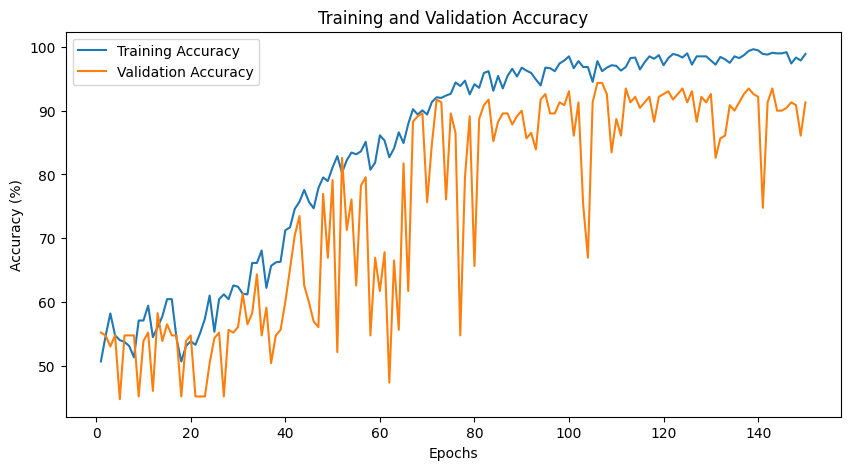

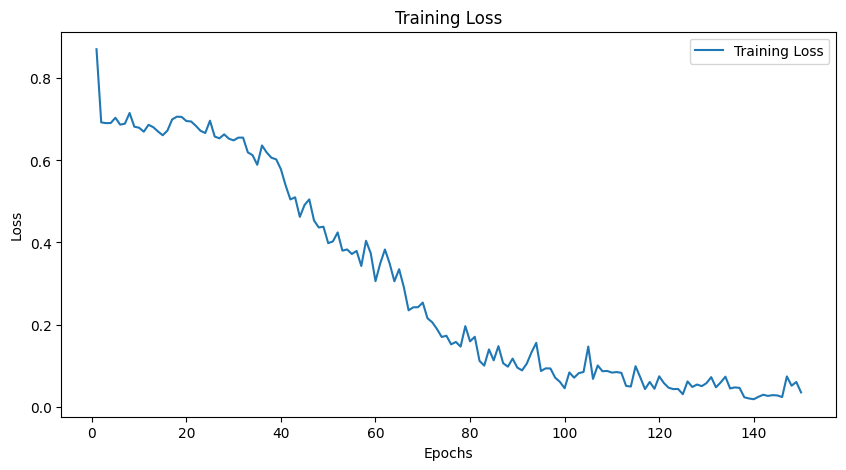

In [5]:
# 设置gpu训练
device = torch.device("cuda")

# 加载处理好的频谱图数据集
train_loader = torch.load('../data/Dataloader_2D/train_loader.pth')
val_loader = torch.load('../data/Dataloader_2D/val_loader.pth')
test_loader = torch.load('../data/Dataloader_2D/test_loader.pth')

# 运行训练和测试
main(train_loader, val_loader, test_loader, device, num_epochs=150)
